<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


#  Instruction-Tuning with LLMs


Instruction-based fine-tuning, referred to as instruction GPT. It trains the language models to follow specific instructions and generate appropriate responses. For instruction-tuning, the dataset plays an important role as it provides structured examples of instructions, contexts, and responses, allowing the model to learn how to handle various tasks effectively. Instruction GPT often uses human feedback to refine and improve model performance; however, this lab doesn't cover this aspect.

The context and instruction are concatenated to form a single input sequence that the model can understand and use to generate the correct response.

#### Context and instruction

	•	Instruction: A command to specify what the model should do
	•	Context: Additional information or background required for performing the instruction
	•	Combined input: The instruction and context combine together into a single input sequence
    


Let's review certain examples for various templates:

---
#### Response template
Template: `### Question: {question}\n ### Answer: {answer}`

Example:
```
### Question: What is the capital of France?
### Answer: Paris
```

---
#### Conversation template

Template: `### User: {user_input}\n ### Bot: {bot_response}`
Example:
```
### User: How are you today?
### Bot: I'm doing great, thank you! How can I assist you today?
```

---
#### Instruction and output template

Template: `### Instruction: {instruction}\n ### Output: {output}`

Example:
```
### Instruction: Translate the following sentence to Spanish: "Hello, how are you?"
### Output: "Hola, ¿cómo estás?"
```

---
#### Completion template

Template: `{prompt} ### Completion: {completion}`
Example:
```
Once upon a time in a faraway land, ### Completion: there lived a wise old owl who knew all the secrets of the forest.
```

#### Summarization template

Template: `### Text: {text}\n ### Summary: {summary}`

Example:
```
### Text: The quick brown fox jumps over the lazy dog.
### Summary: A fox jumps over a dog.
```

---
#### Dialogue template

Template: `### Speaker 1: {utterance_1}\n ### Speaker 2: {utterance_2}\n ### Speaker 1: {utterance_3}`

Example:
```
### Speaker 1: Hi, what are you doing today?
### Speaker 2: I'm going to the park.
### Speaker 1: That sounds fun!
```

---
#### Code generation template

Template: `### Task: {task_description}\n ### Code: {code_output}`

Example:
```
### Task: Write a function to add two numbers in Python.
### Code: def add(a, b):\n    return a + b
```

---
#### Data analysis template

Template: `### Analysis Task: {task_description}\n ### Analysis: {analysis_output}`

Example:
```
### Analysis Task: Provide insights from the sales data of Q1 2022.
### Analysis: The sales increased by 15% compared to Q4 2021, with the highest growth in the electronics category.
```

---
#### Recipe template

Template: `### Recipe Name: {recipe_name}\n ### Ingredients: {ingredients}\n ### Instructions: {instructions}`

Example:
```
### Recipe Name: Chocolate Chip Cookies
### Ingredients: Flour, Sugar, Chocolate Chips, Butter, Eggs, Vanilla Extract
### Instructions: Mix the dry ingredients, add the wet ingredients, fold in the chocolate chips, and bake at 350°F for 10-12 minutes.
```

---
#### Explanation template

Template: `### Concept: {concept}\n ### Explanation: {explanation}`

Example:
```
### Concept: Photosynthesis
### Explanation: Photosynthesis is the process by which green plants use sunlight to synthesize nutrients from carbon dioxide and water.
```

---


## Objectives

After completing this lab, you will be able to:

 - Understand the various types of templates including instruction-response, question-answering, summarization, code generation, dialogue, data analysis, and explanation and their applications for fine-tuning large language models (LLMs).
 - Create and apply different templates to fine-tune LLMs for various tasks.
 - Format datasets based on the created templates to prepare them for effective model training
 - Perform instruction fine-tuning using Hugging Face libraries and tools
 - Apply Low-Rank Adaptation (LoRA) techniques to fine-tune LLMs efficiently
 - Configure and use the SFTTrainer for supervised fine-tuning of instruction-following models


The concepts presented in this lab would apply to the other template formats as well.


# __Table of contents__

<ol>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Install-required-libraries">Install required libraries</a></li>
            <li><a href="#Import-required-libraries">Import required libraries</a></li>
            <li><a href="#Define-the-device">Define the device</a></li>
        </ol>
    </li>
    <li><a href="#Dataset-description">Dataset description</a></li>
    <li><a href="#Model-and-tokenizer">Model and tokenizer</a></li>
    <li><a href="#Preprocessing-the-data">Preprocessing the data</a></li>
    <li><a href="#Test-the-base-model">Test the base model</a></li>
        <ol>
            <li><a href="#BLEU-score">BLEU score</a></li>
        </ol>
    <li><a href="#Perform-instruction-fine-tuning-with-LoRA">Perform instruction fine-tuning with LoRA</a></li>
    <li><a href="#Exercises">Exercises</a></li>
</ol>


# Setup

### Install required libraries

For this lab, use the following libraries, which are __not__ preinstalled in the Skills Network Labs environment. You can install libraries by running the code in the below cell. 


In [1]:
!pip install -qq datasets==2.20.0 trl==0.9.6 transformers==4.42.3 peft==0.11.1 tqdm==4.66.4 numpy==1.26.4 pandas==2.2.2 matplotlib==3.9.1 seaborn==0.13.2 scikit-learn==1.5.1 sacrebleu==2.4.2 evaluate==0.4.2

### Import required libraries

The following code imports the required libraries.


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from datasets import load_dataset
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import evaluate
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM

from peft import get_peft_model, LoraConfig, TaskType

import pickle
import json
import matplotlib.pyplot as plt 

from urllib.request import urlopen
import io

### Define the device

The below code will set your device to 'cuda' if your device is compatible with GPU, otherwise, you can use 'cpu'.


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset description

Use the below sentences to download the CodeAlpaca 20k dataset, a programming code dataset. This code is available [here](https://github.com/sahil280114/codealpaca?tab=readme-ov-file#data-release). The CodeAlpaca dataset contains the following elements:


- `instruction`: **str**, describes the task the model should perform. Each of the 20K instructions is unique.
- `input`: **str**, optional context or input for the task. For example, when the instruction is "Amend the following SQL query to select distinct elements", the input is the SQL query. Around 40% of the examples have an input.
- `output`: **str**, the answer to the instruction as generated by text-davinci-003.

The following code block downloads the training split from the CodeAlpaca-20k dataset:


In [4]:
dataset = load_dataset("lucasmccabe-lmi/CodeAlpaca-20k", split="train")
dataset

Generating train split:   0%|          | 0/20022 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 20022
})

Let's look at the example in the dataset:


In [5]:
dataset[1000]

{'instruction': 'Create a JavaScript code snippet to get a list of all the elements in an array with even index.',
 'input': 'let arr = [1,2,3,4,5,6];',
 'output': 'let evenIndexArr = arr.filter((elem, index) => index % 2 === 0);'}

To keep things simple let's just focus on the examples that do not have any `input`:


In [6]:
dataset = dataset.filter(lambda example: example["input"] == '')

Filter:   0%|          | 0/20022 [00:00<?, ? examples/s]

The original CodeAlpaca dataset may not have been shuffled. The following line indicates how to shuffle a `datasets.arrow_dataset.Dataset()` object with a random seed:


In [7]:
dataset = dataset.shuffle(seed=42)

In [8]:
dataset

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 9764
})

The CodeAlpaca 20k dataset has a training and test set. You can split the original training data into a train and test set by assigning 80% of the data to the training set and 20% to the testing set.


In [9]:
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_split['train']
test_dataset = dataset_split['test']
dataset_split

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 7811
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 1953
    })
})

In [10]:
# Select a small set of data for the resource limitation
# This dataset will be only used for evaluation parts, not for the training
tiny_test_dataset=test_dataset.select(range(10))
tiny_train_dataset=train_dataset.select(range(10))

# Model and tokenizer

In this exercise, let's fine-tune the [`opt-350m`](https://huggingface.co/facebook/opt-350m) model from Facebook. A description of this OpenSource model was published [here](https://arxiv.org/abs/2205.01068), and the model was originally made available on [metaseq's Github repository](https://github.com/facebookresearch/metaseq).

The below lines load the base model from Hugging Face:


In [11]:
# Base model
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m").to(device)

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

This model comes with its own tokenizer which you will be loading here:


In [12]:
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m", padding_side='left')

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Let's find the end of sentence (EOS) token. This is a special tokenizer token. Once this token is encountered, the model will stop generating further tokens:


In [13]:
tokenizer.eos_token

'</s>'

# Preprocessing the data

To perform the fine-tuning, first, preprocess the data by creating functions that generate the prompt.

The `formatting_prompts_func` function takes a dataset as input. For every element in the dataset format, the instruction and the output into a template using the format:

```
### Instruction:
Translate the following sentence to Spanish: "Hello, how are you?"

### Response:
"Hola, ¿cómo estás?</s>"
```

_**Note:**_ 
1. The template provided in this section may differ from the **Instruction and output template** presented in the introduction of this lab. You can replace the  `### Response:` with `### Output:` to generate similar results.

2. Introducing the `</s>` end of sentence token at the end of the text informs the model to stop generating text beyond this point.

Finally, the `formatting_prompts_func_no_response` function behaves similarly to the `formatting_prompts_func` except the response is not included.


In [14]:
def formatting_prompts_func(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (
            f"### Instruction:\n{mydataset['instruction'][i]}"
            f"\n\n### Response:\n{mydataset['output'][i]}</s>"
        )
        output_texts.append(text)
    return output_texts

def formatting_prompts_func_no_response(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (
            f"### Instruction:\n{mydataset['instruction'][i]}"
            f"\n\n### Response:\n"
        )
        output_texts.append(text)
    return output_texts

The following code block generates the `instructions` (the part of the prompt that does not include the response), the `instructions_with_responses` (the full prompt with the response and `eos` token), and the `expected_outputs`, which are the parts of the `instructions_with_responses` that are between the `instructions` and the `eos` token.

To find the `expected_outputs`, tokenize `instructions` and the `instructions_with_responses`. Then, count the number of tokens in `instructions`, and discard the equivalent amount of tokens from the beginning of the tokenized `instructions_with_responses` vector. Finally, discard the final token in `instructions_with_responses`, corresponding to the `eos` token. Decode the resulting vector using the tokenizer, resulting in the `expected_output`:


In [15]:
expected_outputs = []
instructions_with_responses = formatting_prompts_func(test_dataset)
instructions = formatting_prompts_func_no_response(test_dataset)
for i in tqdm(range(len(instructions_with_responses))):
    tokenized_instruction_with_response = tokenizer(instructions_with_responses[i], return_tensors="pt", max_length=1024, truncation=True, padding=False)
    tokenized_instruction = tokenizer(instructions[i], return_tensors="pt")
    expected_output = tokenizer.decode(tokenized_instruction_with_response['input_ids'][0][len(tokenized_instruction['input_ids'][0])-1:], skip_special_tokens=True)
    expected_outputs.append(expected_output)


100%|██████████| 1953/1953 [00:01<00:00, 1387.92it/s]


Let's look at the example to view what `instructions` include, `instructions_with_responses`, and `expected_outputs`:


In [16]:
print('############## instructions ##############\n' + instructions[0])
print('############## instructions_with_responses ##############\n' + instructions_with_responses[0])
print('\n############## expected_outputs ##############' + expected_outputs[0])

############## instructions ##############
### Instruction:
What type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.

### Response:

############## instructions_with_responses ##############
### Instruction:
What type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.

### Response:
The data structure to use for key-value pairs in Python is a dictionary. A dictionary is a data type that consists of key-value pairs, and is denoted by {} in Python. Each key has a unique value associated with it that can be accessed using the key. For example, a dictionary called "person" could look like this: 

person = {'name':'John', 'age': 32} 

The value of the key "name" can be accessed using person['name'] which returns "John".</s>

############## expected_outputs ##############
The data structure to use for key-value pairs in Python is a dictionary. A dictionary is a da

Instead of keeping the instructions as-is, it's beneficial to convert the `instructions` list into a `torch` `Dataset`. The following code defines a class called `ListDataset` that inherits from `Dataset` and creates a `torch` `Dataset` from a list. This class is then used to generate a `Dataset` object from `instructions`: 


In [17]:
class ListDataset(Dataset):
    def __init__(self, original_list):
        self.original_list = original_list
    
    def __len__(self):
        return len(self.original_list)
    
    def __getitem__(self, i):
        return self.original_list[i]

instructions_torch = ListDataset(instructions)

In [18]:
instructions_torch[0]

'### Instruction:\nWhat type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.\n\n### Response:\n'

# Test the base model

Let's understand how the base model performs without performing fine-tuning in the model. This may involve response generation from the base, that is from the non-fine-tuned mode. 


The below code defines a text generation pipeline using the `pipeline` class from `transformers`. This pipeline is useful to generate text given by a model and a tokenizer:


In [19]:
gen_pipeline = pipeline("text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        device=device,
                        batch_size=2,
                        max_length=50,
                        truncation=True,
                        padding=False,
                        return_full_text=False)

**_Note:_** The generation pipeline can generate tokens or text. If```return_tensors=True```, the pipeline returns token IDs; otherwise, it returns words. Additionally, the generation pipeline generates both the instructions *and* the responses by default. However, to assess the model's performance, exclude the generated instructions and focus on the responses. To do this, set ```return_full_text=False```.


The below code leverages the pre-defined generation pipeline to generate outputs using the model. 

**_Note:_** The code is commented out because it may take a long time for CPU. Instead of generating the raw tokens here, you can load output from this model later.


In [20]:
tokenizer.padding_side = 'left'

with torch.no_grad():
    # Due to resource limitation, only apply the function on 3 records using "instructions_torch[:10]"
    pipeline_iterator= gen_pipeline(instructions_torch[:3], 
                                    max_length=50, # this is set to 50 due to resource constraint, using a GPU, you can increase it to the length of your choice
                                    num_beams=5,
                                    early_stopping=True,)

generated_outputs_base = []
for text in pipeline_iterator:
    generated_outputs_base.append(text[0]["generated_text"])

KeyboardInterrupt: 

The below code loads the generated responses for the whole dataset using machine that has access to a fast CUDA-enabled GPU:


In [21]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/VvQRrSqS1P0_GobqtL-SKA/instruction-tuning-generated-outputs-base.pkl')
generated_outputs_base = pickle.load(io.BytesIO(urlopened.read()))

Let's look at the sample responses generated by the base model and the expected responses from the dataset.


In [22]:
for i in range(3):
    print('@@@@@@@@@@@@@@@@@@@@')
    print('@@@@@ Instruction '+ str(i+1) +': ')
    print(instructions[i])
    print('\n\n')
    print('@@@@@ Expected response '+ str(i+1) +': ')
    print(expected_outputs[i])
    print('\n\n')
    print('@@@@@ Generated response '+ str(i+1) +': ')
    print(generated_outputs_base[i])
    print('\n\n')
    print('@@@@@@@@@@@@@@@@@@@@')
    

@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 1: 
### Instruction:
What type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.

### Response:




@@@@@ Expected response 1: 

The data structure to use for key-value pairs in Python is a dictionary. A dictionary is a data type that consists of key-value pairs, and is denoted by {} in Python. Each key has a unique value associated with it that can be accessed using the key. For example, a dictionary called "person" could look like this: 

person = {'name':'John', 'age': 32} 

The value of the key "name" can be accessed using person['name'] which returns "John".



@@@@@ Generated response 1: 
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.



@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@
@

You can see that the responses generated by the base model are not up to the mark. Also, the responses have the tendency to extend and repeat the answers until they generate the maximum number of tokens. Later on, you can see that the instruction-tuning can fix both of these issues. First, the instruction fine-tuned model will be able to provide more meaningful responses. Second, because, you appended the `eos` token `<\s>` to the output, you will teach the model via instruction fine-tuning to not generate responses without bound.


## BLEU score

Let's set up a metric that compares the generated responses and the expected responses in the test environment. In this lab, let's use the [BLEU score](https://en.wikipedia.org/wiki/BLEU), a metric originally intended to check the quality of translations made by translation models. You can calculate the BLEU scores for individual generated segments by comparing them with a set of expected outputs and average the scores for the individual segments. Depending on the implementation, BLEU scores range from 0 to 1 or from 0 to 100 (as in the implementation used herein), with higher scores indicating a better match between the model generated output and the expected output.

_**Note:**_ 
1. The BLEU score was originally implemented for assessing the quality of translations. However, it may not necessarily be the best metric for instruction fine-tuning in general, but it is nonetheless a useful metric that gives a sense of the alignment between the model generated output and the expected output.
2. BLEU scores are very challenging to compare from one study to the next because it is a parametrized metric. As a result, you can employ a variant of BLEU called [SacreBLEU](https://aclanthology.org/W18-6319/) invariant to the metric's parametrization.


In [23]:
sacrebleu = evaluate.load("sacrebleu")
results_base = sacrebleu.compute(predictions=generated_outputs_base,
                                 references=expected_outputs)

print(list(results_base.keys()))
print(round(results_base["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
0.4


The SacreBLEU score of 0.4/100 indicates that there is very little alignment between the base model's generated responses and the expected responses for the examples in the test dataset.


---


## Perform instruction fine-tuning with LoRA


To save time, let's perform instruction fine-tuning using a parameter-efficient fine-tuning (PEFT) method called low-rank adaptation (LoRA).
First, convert the model into a PEFT model suitable for LoRA fine-tuning by defining a `LoraConfig` object from the `peft` library that outlines LoRA parameters, such as the LoRA rank and the target modules. Next, apply LoRA configuration on the model using `get_peft_model()`, which effectively converts `model` into a LoRA `model`.


In [24]:
lora_config = LoraConfig(
    r=16,  # Low-rank dimension
    lora_alpha=32,  # Scaling factor
    target_modules=["q_proj", "v_proj"],  # Modules to apply LoRA
    lora_dropout=0.1,  # Dropout rate
    task_type=TaskType.CAUSAL_LM  # Task type should be causal language model
)

model = get_peft_model(model, lora_config)

Instruction fine-tuning using the `SFTTrainer` has the effect of generating the instructions *and* the responses. However, for the purposes of assessing the quality of the generated text, consider only the quality of the response and not the quality of the instruction. For the purposes of calculating the BLEU score, eliminate the length of tokens corresponding to the instruction from the beginning of the tokenized model output. 

For example, suppose the tokenized instruction had a length of ten, but the generated text had a length of fourteen. Then the tokenized response that was kept for the purposes of calculating the BLEU score was just the four tokens at the end of the tokenized generated text because the first ten tokens represent the model's generation of the tokenized instruction.

Although eliminating the first few tokens of the tokenized output worked well for the purposes of calculating BLEU. However, during fine-tuning, the first few tokens won't have an impact on the loss function. You can mask those tokens using -100 by ignoring the value of PyTorch loss functions such as [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). By masking the tokens corresponding to the instruction with -100, only the tokens associated with the response can bear the loss.

You can create such a masking manually by defining your own function. However, it is easier to instead use the `DataCollatorForCompletionOnlyLM` class from `trl`:


In [25]:
response_template = "### Response:\n"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

Now, pass the `collator`, `DataCollatorForCompletionOnlyLM` object to the data collator into `SFTTrainer`, resulting in the generated instructions without bearing on the loss.

To perform the training, first configure our `SFTTrainer`, and create the `SFTTrainer` object by passing to the `collator`:


In [26]:
training_args = SFTConfig(
    output_dir="/tmp",
    num_train_epochs=10,
    save_strategy="epoch",
    fp16=True,
    per_device_train_batch_size=2,  # Reduce batch size
    per_device_eval_batch_size=2,  # Reduce batch size
    max_seq_length=1024,
    do_eval=True
)

trainer = SFTTrainer(
    model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    formatting_func=formatting_prompts_func,
    args=training_args,
    packing=False,
    data_collator=collator,
)

Map:   0%|          | 0/7811 [00:00<?, ? examples/s]

Map:   0%|          | 0/1953 [00:00<?, ? examples/s]

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Please ignore the above warning.
The below comments, runs the trainer, because this would take a long time on the CPU. Therefore, let's not run the trainer here.


In [ ]:
#trainer.train()

If you want to train the trainer, the `trainer` object would have a state history for every training step. You would be able to access this state history using the below commented out line:


In [ ]:
#log_history_lora = trainer.state.log_history

Instead of extracting the state history above, let's load the state history of a model that was instruction fine-tuned to the above specifications on a GPU.


In [27]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/49I70jQD0-RNRg2v-eOoxg/instruction-tuning-log-history-lora.json')
log_history_lora = json.load(io.BytesIO(urlopened.read()))

You can plot the training loss for each training step.


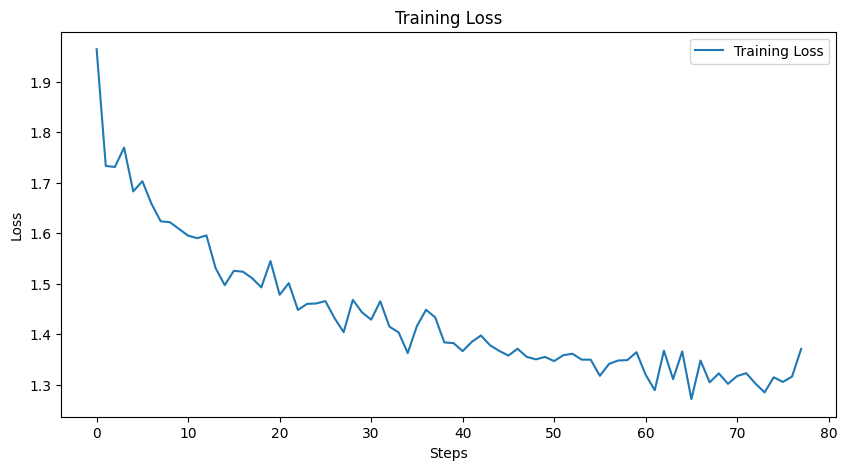

In [28]:
train_loss = [log["loss"] for log in log_history_lora if "loss" in log]

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

If you want to fine-tune the model, the fine-tuned model could be saved using the below commented out line:


In [29]:
#trainer.save_model("./instruction_tuning_final_model_lora")

Let's redefine the text generation pipeline because the model has been changed to the LoRA model. Ignore the warning for the `PeftModelForCausalLM` not being supported for `text-generation`. However, if the PEFT model is supported, the warning is erroneous.


In [30]:
gen_pipeline = pipeline("text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        device=device, 
                        batch_size=2, 
                        max_length=50, 
                        truncation=True, 
                        padding=False,
                        return_full_text=False)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM'

The below code generates tokens with the pipeline using the instruction fine-tuned model. Only three records of data are used for demonstration  because generating text is time consuming on CPU:


In [ ]:
with torch.no_grad():
    # Due to resource limitation, only apply the function on 3 records using "instructions_torch[:10]"
    pipeline_iterator= gen_pipeline(instructions_torch[:3],
                                max_length=50, # this is set to 50 due to resource constraint, using a GPU, you can increase it to the length of your choice
                                num_beams=5,
                                early_stopping=True,)
generated_outputs_lora = []
for text in pipeline_iterator:
    generated_outputs_lora.append(text[0]["generated_text"])

In [ ]:
generated_outputs_lora[0]

You can load the generated texts for the entire dataset from the fine-tuned LoRA model and run on GPU.


In [31]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/o7uYxe15xvX4CN-6Lr10iA/instruction-tuning-generated-outputs-lora.pkl')
generated_outputs_lora = pickle.load(io.BytesIO(urlopened.read()))

Let's have a look at some of the responses from the instruction fine-tuned model and the expected responses.


In [32]:
for i in range(3):
    print('@@@@@@@@@@@@@@@@@@@@')
    print('@@@@@ Instruction '+ str(i+1) +': ')
    print(instructions[i])
    print('\n\n')
    print('@@@@@ Expected response '+ str(i+1) +': ')
    print(expected_outputs[i])
    print('\n\n')
    print('@@@@@ Generated response '+ str(i+1) +': ')
    print(generated_outputs_lora[i])
    print('\n\n')
    print('@@@@@@@@@@@@@@@@@@@@')
    

@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 1: 
### Instruction:
What type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.

### Response:




@@@@@ Expected response 1: 

The data structure to use for key-value pairs in Python is a dictionary. A dictionary is a data type that consists of key-value pairs, and is denoted by {} in Python. Each key has a unique value associated with it that can be accessed using the key. For example, a dictionary called "person" could look like this: 

person = {'name':'John', 'age': 32} 

The value of the key "name" can be accessed using person['name'] which returns "John".



@@@@@ Generated response 1: 
The type of data structure to use to store key-value pairs in a Python program would be a key-value pair.



@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 2: 
### Instruction:
Describe a method to solve an equation of the form ax + b = 0. Write corresponding code in Python.

### R

Compared to the base model, you can see that the responses are much better. Additionally, the responses don't extend until the maximum number of tokens are generated.

To confirm the responses generated by the instruction fine-tuned model align better with the expected output, let's calculate the SacreBLEU score:


In [33]:
sacrebleu = evaluate.load("sacrebleu")
results_lora = sacrebleu.compute(predictions=generated_outputs_lora,
                                 references=expected_outputs)
print(list(results_lora.keys()))
print(round(results_lora["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
14.7


You can see that the fine-tuned model achieves a SacreBLEU score of 14.7/100, significantly better than the 0.4/100 achieved by the base model. 

Let's conclude. The instruction fine-tuned model generates responses that align much better with the expected responses in the dataset.


---


# Exercises


### Exercise 1: Try with another response template (Question-Answering)


Create a `formatting_prompts_response_template` function to format the train_dataset in the Response Template. 


Template: `### Question: {question}\n ### Answer: {answer}`


In [34]:
#write your code here

def formatting_prompts_response_template(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (
            f"### Question:\n{mydataset['instruction'][i]}"
            f"\n\n### Answer:\n{mydataset['output'][i]}</s>"
        )
        output_texts.append(text)
    return output_texts

<details>
    <summary>Click here for the solution</summary>

```python
def formatting_prompts_response_template(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (
            f"### Question:\n{mydataset['instruction'][i]}"
            f"\n\n### Answer:\n{mydataset['output'][i]}</s>"
        )
        output_texts.append(text)
    return output_texts
```

</details>


Create a `formatting_prompts_response_template_no_response` function to format the `test_dataset` in the Response Template, excluding the response.


Template: `### Question: {question}\n ### Answer: `


In [35]:
#write your code here

def formatting_prompts_response_template_no_response(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (
            f"### Question:\n{mydataset['instruction'][i]}"
            f"\n\n### Answer:\n"
        )
        output_texts.append(text)
    return output_texts

<details>
    <summary>Click here for the solution</summary>

```python
def formatting_prompts_response_template_no_response(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (
            f"### Question:\n{mydataset['instruction'][i]}"
            f"\n\n### Answer:\n"
        )
        output_texts.append(text)
    return output_texts
```

</details>


### Exercise 2: Try with another LLM (EleutherAI/gpt-neo-125m)



The EleutherAI/gpt-neo-125m is a smaller variant of the GPT-Neo family of models developed by EleutherAI. With 125 million parameters, it is designed to be computationally efficient while still providing robust performance for various natural language processing tasks.


Download and load the `EleutherAI/gpt-neo-125m` model


In [36]:
#write your code here

model_name = "EleutherAI/gpt-neo-125m"

# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

<details>
    <summary>Click here for the solution</summary>

```python
model_name = "EleutherAI/gpt-neo-125m"

# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
```

</details>


Initialize LoRA Configuration:

- r: 8 (Low-rank dimension)
- lora_alpha: 16 (Scaling factor)
- target_modules: ["q_proj", "v_proj"] (Modules to apply LoRA)
- lora_dropout: 0.1 (Dropout rate)
- task_type: TaskType.CAUSAL_LM (Task type should be causal language model)


In [38]:
#write your code here

lora_config = LoraConfig(
    r=8,  # Low-rank dimension
    lora_alpha=16,  # Scaling factor
    target_modules=["q_proj", "v_proj"],  # Modules to apply LoRA
    lora_dropout=0.1,  # Dropout rate
    task_type=TaskType.CAUSAL_LM  # Task type should be causal language model
)

<details>
    <summary>Click here for the solution</summary>

```python

lora_config = LoraConfig(
    r=8,  # Low-rank dimension
    lora_alpha=16,  # Scaling factor
    target_modules=["q_proj", "v_proj"],  # Modules to apply LoRA
    lora_dropout=0.1,  # Dropout rate
    task_type=TaskType.CAUSAL_LM  # Task type should be causal language model
)
```

</details>


Apply LoRA Configuration to the model.


In [39]:
#write your code here
model = get_peft_model(model, lora_config)

In [40]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPTNeoForCausalLM(
      (transformer): GPTNeoModel(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(2048, 768)
        (drop): Dropout(p=0.0, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPTNeoBlock(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPTNeoAttention(
              (attention): GPTNeoSelfAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
                (resid_dropout): Dropout(p=0.0, inplace=False)
                (k_proj): Linear(in_features=768, out_features=768, bias=False)
                (v_proj): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=False)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features

<details>
    <summary>Click here for the solution</summary>

```python
model = get_peft_model(model, lora_config)
```

</details>


## Congratulations! You have completed the lab


## Authors


[Wojciech "Victor" Fulmyk](https://www.linkedin.com/in/wfulmyk) is a Data Scientist and a PhD Candidate in Economics at the University of Calgary.


[Fateme Akbari](https://www.linkedin.com/in/fatemeakbari/) is a Ph.D. candidate in Information Systems at McMaster University with demonstrated research experience in Machine Learning and NLP.


[Joseph Santarcangelo](https://author.skills.network/instructors/joseph_santarcangelo) has a Ph.D. in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


## References

[Supervised Fine-tuning Trainer](https://huggingface.co/docs/trl/main/en/sft_trainer)

[Finetuning To Follow Instructions](https://github.com/rasbt/LLMs-from-scratch/blob/main/ch07/01_main-chapter-code/ch07.ipynb)

[Finetuning with LoRA -- A Hands-On Example](https://lightning.ai/lightning-ai/studios/code-lora-from-scratch)


```{## Change Log|Date (YYYY-MM-DD)|Version|Changed By|Change Description||-|-|-|-||2024-07-18|1.0|Wojciech "Victor" Fulmyk|Lab Written||2024-07-25|2.0|Fateme Akbari|Bugs Fixed||2024-07-31|3.0|Bhavika Chhatbar|ID reviewed|}



© Copyright IBM Corporation. All rights reserved.
